In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from scipy import stats

In [3]:
import json
plt_properties = json.load(open('utils/plt_properties.json'))
fig_width = plt_properties['fig_width']
plt.rcParams.update(plt_properties['plt_params'])

In [4]:
sys.path.append(os.path.join(os.getcwd(), 'utils'))
from bland_altman import bland_altman_plot
from correlation import plot_regression
from distributions import density_plot
from permutation_test import permutation_test_repeated
from variables import target_col

In [5]:
df = pd.read_csv('../Data/dataset_mlr.csv')

/tmp/ipykernel_7203/900100850.py:1: DtypeWarning: Columns (12,22,23,24,25,35,36,37,38,39,44,48,49,53,54,55,61,72,76,121,122,124,125,127,136,138,139,140,141,142,143,144,152,157,158,159,161,162,163,210,216,218,219,221,233,251,252,254,503,509,511,513,515,519,523,525,527,529) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/dataset_mlr.csv')


# 8) Intersalt

Developed for spot urine samples.  
Here: analyse if valid (summarise results w.r.t. night spot measurements...).  

## 8.1) Distributions

In [6]:
df_sub = df[~df.una_ud_mmol_intersalt.isna() * ~df.una_un_mmol_intersalt.isna()]

In [7]:
print(f'Removed samples: {len(df) - len(df_sub)}')

Removed samples: 4


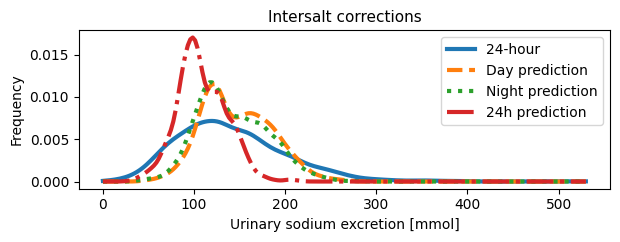

In [8]:
fig, ax = plt.subplots(figsize=(fig_width, 0.4 * fig_width))

max_ = np.max([df_sub[target_col], df_sub.una_ud_mmol_intersalt, df_sub.una_un_mmol_intersalt])
density_plot(df_sub[target_col], ax, max_, linestyle='-', label='24-hour')
density_plot(df_sub.una_ud_mmol_intersalt, ax, max_, linestyle='--', label='Day prediction')
density_plot(df_sub.una_un_mmol_intersalt, ax, max_, linestyle=':', label='Night prediction')
density_plot(df_sub.una_u24_mmol_intersalt, ax, max_, linestyle='-.', label='24h prediction')

ax.legend()
ax.set_xlabel('Urinary sodium excretion [mmol]')
ax.set_ylabel('Frequency')
ax.set_title('Intersalt corrections')

fig.tight_layout()

In [9]:
preds = df_sub.una_un_mmol_intersalt

print('Significant difference distribution:', round(stats.wilcoxon(df_sub[target_col], preds).pvalue, 4))

def mean(x, y, axis=None):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def mean_perm_test_repeated(x, y, x_id, y_id):
    return permutation_test_repeated(
        x, y, x_id, y_id, mean, n_resamples=1e4, permutation_type='samples', alternative='two-sided', random_state=42
    ).pvalue

print(f'Significant difference mean ({round(df_sub[target_col].mean(), 1)} vs {round(preds.mean(), 1)}):',
      round(mean_perm_test_repeated(df_sub[target_col], preds, df_sub['sk1_id'], df_sub['sk1_id']), 4))

def median(x, y, axis=None):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

def median_perm_test_repeated(x, y, x_id, y_id):
    return permutation_test_repeated(
        x, y, x_id, y_id, median, n_resamples=1e4, permutation_type='samples', alternative='two-sided', random_state=42
    ).pvalue

print(f'Significant difference median ({round(df_sub[target_col].median(), 1)} vs {round(preds.median(), 1)}):',
      round(median_perm_test_repeated(df_sub[target_col], preds, df_sub['sk1_id'], df_sub['sk1_id']), 4))

def std(x, y, axis=None):
    return np.std(x, axis=axis) - np.std(y, axis=axis)

def std_perm_test_repeated(x, y, x_id, y_id):
    return permutation_test_repeated(
        x, y, x_id, y_id, std, n_resamples=1e4, permutation_type='samples', alternative='two-sided', random_state=42
    ).pvalue

print(f'Significant difference std ({round(df_sub[target_col].std(), 1)} vs {round(preds.std(), 1)}):',
      round(std_perm_test_repeated(df_sub[target_col], preds, df_sub['sk1_id'], df_sub['sk1_id']), 4))

/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/scipy/stats/_resampling.py:840: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


Significant difference distribution: 0.0016
Significant difference mean (140.2 vs 141.9): 0.207


/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/scipy/stats/_resampling.py:840: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


Significant difference median (131.8 vs 135.8): 0.039
Significant difference std (59.8 vs 38.0): 0.0002


In [10]:
rmse_intersalt = np.mean((df_sub.una_un_mmol_intersalt - df_sub[target_col]) ** 2) ** 0.5
print(f'RMSE predictions from night-time: {round(rmse_intersalt, 2)}')

RMSE predictions from night-time: 49.86


## 8.2) Correlations

Coeffs: [0.87930245]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.8793      0.031     28.145      0.000       0.818       0.941
Coeffs: [0.94471412]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9447      0.030     31.142      0.000       0.885       1.004
Coeffs: [0.89598488]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.8960      0.048     18.476      0.000       0.801  

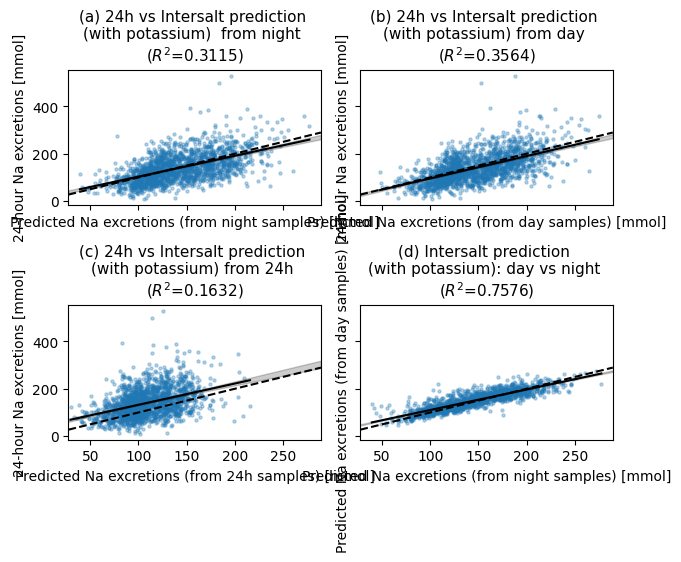

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(fig_width, 0.8 * fig_width), sharex=True, sharey=True)

# 24h vs night
r_squared = plot_regression(df_sub.una_un_mmol_intersalt, df_sub[target_col], ax[0, 0])
ax[0, 0].set(xlabel='Predicted Na excretions (from night samples) [mmol]', ylabel='24-hour Na excretions [mmol]',
          title=f'(a) 24h vs Intersalt prediction \n(with potassium)  from night \n($R^2$={round(r_squared, 4)})')

# 24h vs day
r_squared = plot_regression(df_sub.una_ud_mmol_intersalt, df_sub[target_col], ax[0, 1])
ax[0, 1].set(xlabel='Predicted Na excretions (from day samples) [mmol]', ylabel='24-hour Na excretions [mmol]',
          title=f'(b) 24h vs Intersalt prediction \n(with potassium) from day \n($R^2$={round(r_squared, 4)})')

# 24h vs 24hpred
r_squared = plot_regression(df_sub.una_u24_mmol_intersalt, df_sub[target_col], ax[1, 0])
ax[1, 0].set(xlabel='Predicted Na excretions (from 24h samples) [mmol]', ylabel='24-hour Na excretions [mmol]',
          title=f'(c) 24h vs Intersalt prediction \n(with potassium) from 24h \n($R^2$={round(r_squared, 4)})')

# day vs night
r_squared = plot_regression(df_sub.una_un_mmol_intersalt, df_sub.una_ud_mmol_intersalt, ax[1, 1])
ax[1, 1].set(xlabel='Predicted Na excretions (from night samples) [mmol]', ylabel='Predicted Na excretions (from day samples) [mmol]',
          title=f'(d) Intersalt prediction \n(with potassium): day vs night \n($R^2$={round(r_squared, 4)})')

fig.tight_layout()

## 8.3) Bland-Altman

### 8.3.1) Absolute differences

#### 8.3.1.1) W.r.t. mean

R[write to console]: Loading required package: nlme



[1] "CAUTION! Parametric bootstrap implementation differs from Parker et al. This feature should be considered experimental."
[1] "Running bootstrap; this could take a while..."
================================================================================p-value no correlation x-y: 0.00019998000199980003.


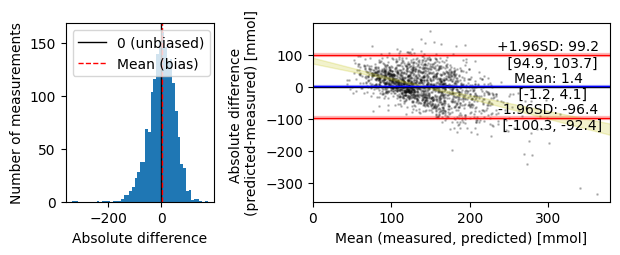

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.4 * fig_width), gridspec_kw={'width_ratios': [1, 2]})
diff = bland_altman_plot(df_sub[target_col], df_sub.una_un_mmol_intersalt, df_sub['sk1_id'], ax=ax[1])
ax[0].hist(diff, bins=50)
ax[0].axvline(0, c='k', linewidth=1, label='0 (unbiased)')
ax[0].axvline(np.mean(diff), c='r', linewidth=1, linestyle='--', label='Mean (bias)')
ax[0].set_xlabel('Absolute difference')
ax[0].set_ylabel('Number of measurements')
ax[0].legend(loc='upper left')
fig.tight_layout()

#### 8.3.1.2) W.r.t. 24-h measurements

[1] "CAUTION! Parametric bootstrap implementation differs from Parker et al. This feature should be considered experimental."
[1] "Running bootstrap; this could take a while..."
================================================================================p-value no correlation x-y: 0.00019998000199980003.


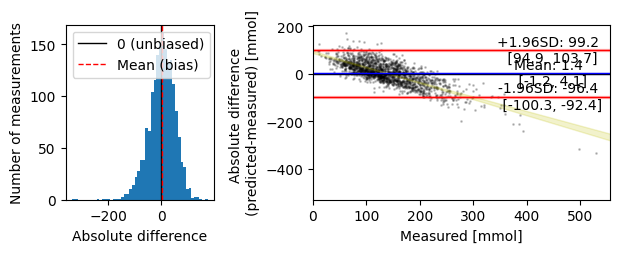

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.4 * fig_width), gridspec_kw={'width_ratios': [1, 2]})
diff = bland_altman_plot(df_sub[target_col], df_sub.una_un_mmol_intersalt, df_sub['sk1_id'], ax=ax[1], x_true=True)
ax[0].hist(diff, bins=50)
ax[0].axvline(0, c='k', linewidth=1, label='0 (unbiased)')
ax[0].axvline(np.mean(diff), c='r', linewidth=1, linestyle='--', label='Mean (bias)')
ax[0].set_xlabel('Absolute difference')
ax[0].set_ylabel('Number of measurements')
ax[0].legend(loc='upper left')
fig.tight_layout()

### 8.3.2) Relative differences

[1] "CAUTION! Parametric bootstrap implementation differs from Parker et al. This feature should be considered experimental."
[1] "Running bootstrap; this could take a while..."
================================================================================p-value no correlation x-y: 0.00019998000199980003.


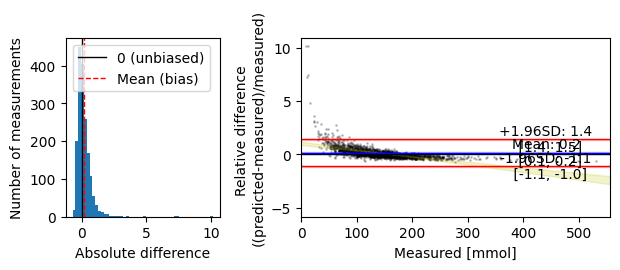

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.4 * fig_width), gridspec_kw={'width_ratios': [1, 2]})
diff = bland_altman_plot(df_sub[target_col], df_sub.una_un_mmol_intersalt, df_sub['sk1_id'], ax=ax[1], relative=True, x_true=True)
ax[0].hist(diff, bins=50)
ax[0].axvline(0, c='k', linewidth=1, label='0 (unbiased)')
ax[0].axvline(np.mean(diff), c='r', linewidth=1, linestyle='--', label='Mean (bias)')
ax[0].set_xlabel('Absolute difference')
ax[0].set_ylabel('Number of measurements')
ax[0].legend(loc='upper left')
fig.tight_layout()

## 8.4) Intra-individual

In [15]:
df_j = df_sub[df_sub['source'] == 'sk1'].join(
    df_sub[df_sub['source'] == 'sk2'].set_index('sk1_id'),
    on='sk1_id', how='inner',
    lsuffix='_sk1', rsuffix='_sk2')

Coeffs: [0.30491289]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.3049      0.033      9.147      0.000       0.239       0.370
$R^2$=0.1122152913134431
Coeffs: [0.14416501]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1442      0.023      6.178      0.000       0.098       0.190
$R^2$=0.054514962516643006


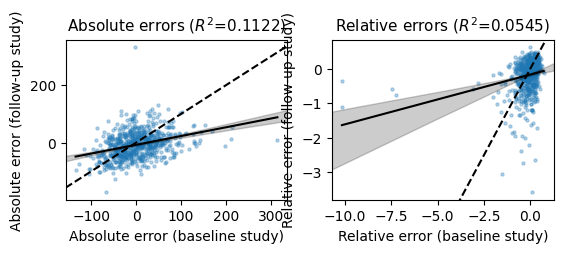

In [16]:
abs_err1 = df_j[target_col + '_sk1'] - df_j['una_un_mmol_intersalt_sk1']
abs_err2 = df_j[target_col + '_sk2'] - df_j['una_un_mmol_intersalt_sk2']
rel_err1 = abs_err1 / df_j[target_col + '_sk1']
rel_err2 = abs_err2 / df_j[target_col + '_sk2']

fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.33 * fig_width))

r_squared = plot_regression(abs_err1, abs_err2, ax=ax[0])
ax[0].set(xlabel='Absolute error (baseline study)', ylabel='Absolute error (follow-up study)',
          title=f'Absolute errors ($R^2$={round(r_squared, 4)})')
print(f'$R^2$={r_squared}')

r_squared = plot_regression(rel_err1, rel_err2, ax=ax[1])
ax[1].set(xlabel='Relative error (baseline study)', ylabel='Relative error (follow-up study)',
          title=f'Relative errors ($R^2$={round(r_squared, 4)})')
print(f'$R^2$={r_squared}')

## 8.5) Bias hypertension

In [17]:
def mean(x, y, axis=None):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def mean_perm_test_repeated(diff1, diff2, diff1_id, diff2_id):
    return permutation_test_repeated(diff1, diff2, diff1_id, diff2_id, mean, n_resamples=1e4,
        permutation_type='independent', alternative='two-sided', random_state=42).pvalue

[1] "CAUTION! Parametric bootstrap implementation differs from Parker et al. This feature should be considered experimental."
[1] "Running bootstrap; this could take a while..."
================================================================================p-value no correlation x-y: 0.00019998000199980003.
[1] "CAUTION! Parametric bootstrap implementation differs from Parker et al. This feature should be considered experimental."
[1] "Running bootstrap; this could take a while..."
================================================================================p-value no correlation x-y: 0.00019998000199980003.
p-value different: 0.0


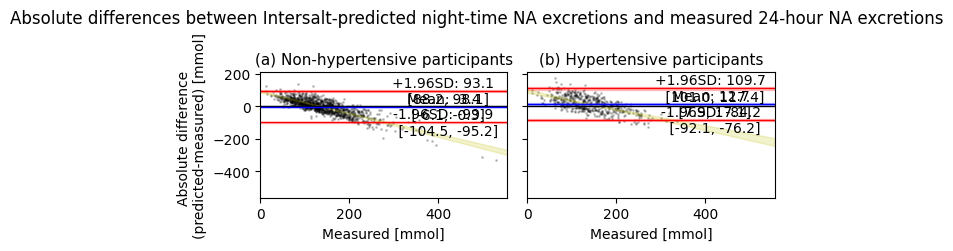

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.4 * fig_width), sharey=True, sharex=True)
fig.suptitle('Absolute differences between Intersalt-predicted night-time NA excretions and measured 24-hour NA excretions')

df_nohyp = df_sub[df_sub['hypertension_combined']=='No']
df_hyp = df_sub[df_sub['hypertension_combined']=='Yes']
diff_nohyp = bland_altman_plot(df_nohyp[target_col], df_nohyp.una_un_mmol_intersalt, df_nohyp['sk1_id'], ax=ax[0], x_true=True, spacing=0.75)
diff_hyp = bland_altman_plot(df_hyp[target_col], df_hyp.una_un_mmol_intersalt, df_hyp['sk1_id'], ax=ax[1], x_true=True, spacing=0.75)
print('p-value different:', round(mean_perm_test_repeated(diff_nohyp, diff_hyp, df_nohyp['sk1_id'], df_hyp['sk1_id']), 3))
ax[1].set_ylabel('')
ax[0].set_title('(a) Non-hypertensive participants')
ax[1].set_title('(b) Hypertensive participants')
fig.tight_layout()